# Training a summarization model

Fine Tuning Facebook's bart-large-cnn summarization model on SamSum

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from transformers import pipeline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
!pip install py7zr # File Compression etc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.9 MB/s eta 0:00:00:00:01


In [3]:
!pip install wandb

In [4]:
import wandb
wandb.init(project="FineTune-TextSummarize", name="DhivyeshRK")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
import pandas as pd
from datasets import Dataset 

df_train = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv')
df_test = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv')
df_val = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv')

df_train = df_train.dropna()
df_test = df_test.dropna()
df_val = df_val.dropna()

In [8]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Convert DataFrames to Hugging Face Datasets
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
dataset_val = Dataset.from_pandas(df_val)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'validation': dataset_val
})

print(dataset_dict)
dataset_samsum = dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', '__index_level_0__'],
        num_rows: 14731
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


In [9]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', '__index_level_0__'],
        num_rows: 14731
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [10]:
dataset_samsum["train"][:10]

{'id': ['13818513',
  '13728867',
  '13681000',
  '13730747',
  '13728094',
  '13716343',
  '13611672',
  '13730463',
  '13809976',
  '13809912'],
 'dialogue': ["Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
  'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great',
  "Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",
  "Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: 

In [11]:
# Get lengths of train, test and val data
split_train_test_val = [len(dataset_samsum[split]) for split in dataset_samsum]

In [12]:
split_train_test_val

[14731, 819, 818]

The "dialogue" field contains the full text and the "summary" the summarized dialogue. 

In [13]:
print(f"Split lengths: {split_train_test_val}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14731, 819, 818]
Features: ['id', 'dialogue', 'summary', '__index_level_0__']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


# Evaluating bart-large-cnn on SAMSum

Lets see how to bart-large-cnn model behaves with samsum using the summarization pipeline

In [14]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")

The result is fine but not as accurate or concise. The model also hallucinates somewhat.

In [15]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 142, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


Summary:
Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah asks Larry. Amanda asks Larry to text him. Hannah says she'll text him back. Hannah calls it a day and says she's going to go home. Hannah: "Bye bye"


### Fine-Tuning PEGASUS

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Shift all computations to GPU

In [17]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [18]:
# Lists of dialogue and summary lengths in the samsum dataset after encoding.
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


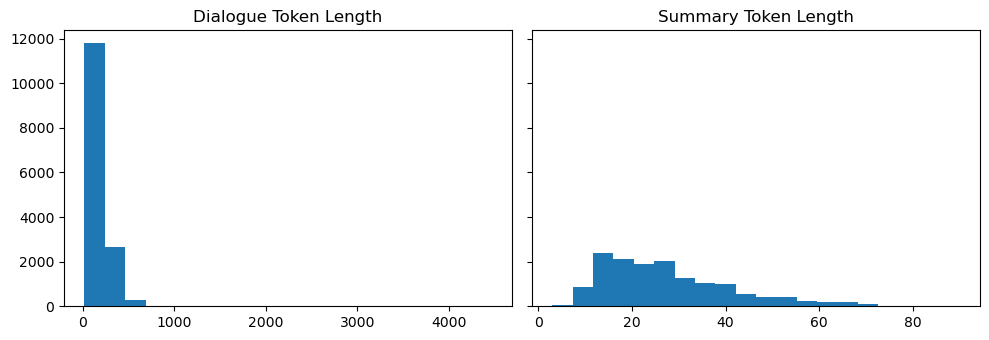

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Dialogue Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary Token Length")
plt.tight_layout()
plt.show()

In [20]:
#lets tokenize the dataset

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    
    #Using target_tokenizer for summaries 
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
        
    return {
        "input_ids": input_encodings["input_ids"], 
        "attention_mask": input_encodings["attention_mask"],  
        "labels": target_encodings["input_ids"]
    }

In [21]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [23]:
from transformers import DataCollatorForSeq2Seq
# Collator for Handling length imbalances and attention masks 
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [24]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments( output_dir="bart-large-cnn-samsum",
                                 num_train_epochs=1,
                                 warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_gpu_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10, 
                                 push_to_hub=True,
                                 evaluation_strategy='steps', 
                                 eval_steps=500,
                                 save_steps=1e6,
                                 gradient_accumulation_steps=16,
                                 report_to="wandb" )

In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [27]:
trainer = Trainer(model=model, 
                 args=training_args,
                 tokenizer=tokenizer,
                 data_collator=seq2seq_data_collator,
                 train_dataset=dataset_samsum_pt["train"],
                 eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/dhivyeshrk/pegasus-samsum into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.74k/2.13G [00:00<?, ?B/s]

Download file spiece.model:   1%|1         | 24.0k/1.82M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.81k/3.81k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##6       | 1.00k/3.81k [00:00<?, ?B/s]

Clean file spiece.model:   0%|          | 1.00k/1.82M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/2.13G [00:00<?, ?B/s]

In [28]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.368900,1.496344


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


TrainOutput(global_step=920, training_loss=1.3889438473660014, metrics={'train_runtime': 1482.2075, 'train_samples_per_second': 9.939, 'train_steps_per_second': 0.621, 'total_flos': 4938357334081536.0, 'train_loss': 1.3889438473660014, 'epoch': 1.0})

In [29]:
trainer.push_to_hub("Training done for bart-large-cnn")

Upload file pytorch_model.bin:   0%|          | 1.00/1.51G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.81k [00:00<?, ?B/s]

To https://huggingface.co/dhivyeshrk/pegasus-samsum
   69a0495..dce2134  main -> main

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
To https://huggingface.co/dhivyeshrk/pegasus-samsum
   dce2134..c8d8b65  main -> main



'https://huggingface.co/dhivyeshrk/pegasus-samsum/commit/dce2134b585502a7d329a3917643ca93d5b84d09'